In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin
import matplotlib.pyplot as plt
import joblib
import shap

In [2]:
def create_time_lagged_features(df, target_col, hours_ahead=6):
    """
    Create time-shifted features for prediction
    """
    df = df.sort_values('date')
    
    # Create lagged features 
    for col in df.select_dtypes(include=[np.number]).columns:
        if col not in ['hour', 'month', 'day', 'day_of_week', 'longitude', 'latitude', 'departures', 'STL1_GDS0_DBLY']:
            df[f'{col}_lag1'] = df[col].shift(1)
            df[f'{col}_lag3'] = df[col].shift(3)
            df[f'{col}_lag6'] = df[col].shift(6)
            df[f'{col}_lag12'] = df[col].shift(12)
    
    # Create target variable
    df['target'] = df[target_col].shift(-hours_ahead)
    df = df[~df['target'].isnull()]
    return df

def preprocess_data(df, era5=False, hours_ahead=6):
    """
    Preprocess the weather data for model training with time-shifted features
    """
    # Convert date to useful features
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.dayofweek

    # Handle missing values
    for col in ['low_availability', 'high_availability', 'departures', 'complete']:
        df[col] = df[col].fillna(0)

    # Select relevant features
    base_features = [
        'longitude', 'latitude', 'hour', 'month', 'day', 'day_of_week',
        'STL1_GDS0_DBLY', '2T_GDS0_SFC', 'low_availability', 'high_availability',
        'complete', '2D_GDS0_SFC', 'STL2_GDS0_DBLY', 'STL3_GDS0_DBLY', 
        'SKT_GDS0_SFC', 'STL4_GDS0_DBLY', 'population', 'departures'
    ]

    # Remove features not available in ERA5 dataset
    if era5:
        base_features = [f for f in base_features if f not in 
                        ['departures', 'population', 'low_availability', 
                         'high_availability', 'complete']]
    
    # Create time-lagged features
    df = create_time_lagged_features(df[base_features + ['date']], 'STL1_GDS0_DBLY', hours_ahead)   
    df = df.drop(columns=['date', 'STL1_GDS0_DBLY'])
    
    return df

In [3]:
class WeatherEnsemble(BaseEstimator, RegressorMixin):
    """
    Stacking ensemble for weather prediction that combines multiple models
    """
    def __init__(self, n_splits=5):
        self.n_splits = n_splits
        
        # Base models
        self.model1 = XGBRegressor(
            n_estimators=30,
            max_depth=6,
            learning_rate=0.1,
            n_jobs=-1,
            random_state=42
        )
        
        self.model2 = RandomForestRegressor(
            n_estimators=30,
            max_depth=6,
            min_samples_split=5,
            n_jobs=-1,
            random_state=42
        )
        
        self.model3 = LGBMRegressor(
            n_estimators=30,
            max_depth=6,
            learning_rate=0.1,
            n_jobs=-1,
            random_state=42
        )
        
        # Meta-learner to optimally combine the predictions from base models
        self.meta_learner = ElasticNetCV(
            l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
            n_jobs=-1,  
            random_state=42,
            cv=3
        )
        
        self.base_models = [self.model1, self.model2, self.model3]
        self.scaler = StandardScaler()
        
    def fit(self, X, y):
        """
        Train the ensemble on the given data
        """
        # Scale features
        X_scaled = self.scaler.fit_transform(X)
        
        # Train base models
        print("Training base models...")
        for i, model in enumerate(self.base_models, 1):
            print(f"Training model {i}...")
            model.fit(X_scaled, y)
        
        # Generate predictions for meta-learner
        meta_features = np.column_stack([
            model.predict(X_scaled) for model in self.base_models
        ])
        
        # Train meta-learner
        print("Training meta-learner...")
        self.meta_learner.fit(meta_features, y)
        return self
    
    def predict(self, X):
        """
        Generate predictions using the ensemble
        """
        # Scale features
        X_scaled = self.scaler.transform(X)
        
        # Generate base model predictions
        meta_features = np.column_stack([
            model.predict(X_scaled) for model in self.base_models
        ])
        
        # Generate final predictions using meta-learner
        return self.meta_learner.predict(meta_features)

    def get_meta_learner_weights(self):
        """
        Get the weights assigned to each base model by the meta-learner
        """
        model_names = ['XGB', 'Random Forest', 'LGBM']
        weights = self.meta_learner.coef_
        
        for name, weight in zip(model_names, weights):
            print(f"{name} weight: {weight:.3f}")

        # Plot the weights
        plt.bar(model_names, weights)
        plt.ylabel('Weight')
        plt.title('Model Weights')
        plt.show()
    
    def save(self, filename):
        """Save the ensemble model"""
        joblib.dump(self, filename)
    
    @classmethod
    def load(cls, filename):
        """Load a saved ensemble model"""
        return joblib.load(filename)

In [4]:
def evaluate_model(model, X, y, set_name=""):
    """
    Evaluate model performance with multiple metrics
    """
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    r2 = 1 - (((y - predictions) ** 2).sum() / ((y - y.mean()) ** 2).sum())
    
    print(f'{set_name} Results:')
    print(f'R² Score: {r2:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {np.sqrt(mse):.4f}\n')
    
    return predictions

def plot_feature_importance(model, X, title):
    """
    Extract and plot feature importance from the Gradient Boosting model
    """
    # Get feature importance from the third base model (LGBM)
    gb_model = model.base_models[2]
    feature_importances = gb_model.feature_importances_
    
    # Create DataFrame of features and their importance scores
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importances
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('importance', ascending=True)
    
    # Plot top 15 features
    plt.figure(figsize=(8, 6))
    importance_df.tail(15).plot(x='feature', y='importance', kind='barh')
    plt.title(f'Top 15 Feature Importance - {title}')
    plt.xlabel('Importance Score')
    plt.tight_layout()

def plot_shap_values(model, X, title, max_display=15):
    # Get the third base model (LGBM)
    gb_model = model.base_models[2]
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(gb_model)
    shap_values = explainer.shap_values(X)
    
    # If output is a list (for multi-class problems), take the first element
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    
    # Plot 1: Summary plot (shows feature importance and impact direction)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values, 
        X,
        max_display=max_display,
        plot_type="bar",
        show=False
    )
    plt.title(f'SHAP Feature Importance - {title}', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Beeswarm plot (shows feature value impact)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values, 
        X,
        max_display=max_display,
        show=False
    )
    plt.title(f'SHAP Value Distribution - {title}', pad=20)
    plt.tight_layout()
    plt.show()

def evaluate_time_windows(df, era5_model, non_era5_model, max_hours=48, step_hours=6, plot=True):
    """
    Evaluate and compare ERA5 and non-ERA5 models across different time windows
    """
    results = []
    windows = range(step_hours, max_hours + step_hours, step_hours)
    
    # Process both models
    for hours_ahead in windows:
        # Preprocess data for both scenarios
        df_era5 = preprocess_data(df.copy(), era5=True, hours_ahead=hours_ahead)
        df_non_era5 = preprocess_data(df.copy(), era5=False, hours_ahead=hours_ahead)
        
        # Split features and target for both datasets
        y_era5 = df_era5['target']
        X_era5 = df_era5.drop(columns=['target'])
        y_non_era5 = df_non_era5['target']
        X_non_era5 = df_non_era5.drop(columns=['target'])
        
        # Use same train/test split ratio
        train_size = int(len(X_era5) * 0.85)
        X_test_era5 = X_era5[train_size:].bfill().ffill()
        y_test_era5 = y_era5[train_size:]
        X_test_non_era5 = X_non_era5[train_size:].bfill().ffill()
        y_test_non_era5 = y_non_era5[train_size:]
        
        # Generate predictions
        predictions_era5 = era5_model.predict(X_test_era5)
        predictions_non_era5 = non_era5_model.predict(X_test_non_era5)
        
        # Calculate metrics for both models
        results.append({
            'hours_ahead': hours_ahead,
            'rmse_era5': np.sqrt(mean_squared_error(y_test_era5, predictions_era5)),
            'mae_era5': mean_absolute_error(y_test_era5, predictions_era5),
            'r2_era5': 1 - (((y_test_era5 - predictions_era5) ** 2).sum() / 
                           ((y_test_era5 - y_test_era5.mean()) ** 2).sum()),
            'rmse_non_era5': np.sqrt(mean_squared_error(y_test_non_era5, predictions_non_era5)),
            'mae_non_era5': mean_absolute_error(y_test_non_era5, predictions_non_era5),
            'r2_non_era5': 1 - (((y_test_non_era5 - predictions_non_era5) ** 2).sum() / 
                               ((y_test_non_era5 - y_test_non_era5.mean()) ** 2).sum())
        })
    
    results_df = pd.DataFrame(results)
    
    if plot:
        # Create a figure with 1x3 subplots
        plt.figure(figsize=(20, 5))
        
        # Plot RMSE comparison
        plt.subplot(1, 3, 1)
        plt.plot(results_df['hours_ahead'], results_df['rmse_era5'], 
                marker='o', linestyle='-', linewidth=2, label='ERA5')
        plt.plot(results_df['hours_ahead'], results_df['rmse_non_era5'], 
                marker='s', linestyle='-', linewidth=2, label='Full Model')
        plt.title('RMSE Comparison')
        plt.xlabel('Hours Ahead')
        plt.ylabel('RMSE (°C)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Plot MAE comparison
        plt.subplot(1, 3, 2)
        plt.plot(results_df['hours_ahead'], results_df['mae_era5'], 
                marker='o', linestyle='-', linewidth=2, label='ERA5')
        plt.plot(results_df['hours_ahead'], results_df['mae_non_era5'], 
                marker='s', linestyle='-', linewidth=2, label='Full Model')
        plt.title('MAE Comparison')
        plt.xlabel('Hours Ahead')
        plt.ylabel('MAE (°C)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Plot R² comparison
        plt.subplot(1, 3, 3)
        plt.plot(results_df['hours_ahead'], results_df['r2_era5'], 
                marker='o', linestyle='-', linewidth=2, label='ERA5')
        plt.plot(results_df['hours_ahead'], results_df['r2_non_era5'], 
                marker='s', linestyle='-', linewidth=2, label='Full Model')
        plt.title('R² Score Comparison')
        plt.xlabel('Hours Ahead')
        plt.ylabel('R² Score')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # # Create a separate figure for feature importance
        # plt.figure(figsize=(20, 6))
        
        # plt.subplot(1, 2, 1)
        # plot_feature_importance(era5_model, X_era5, 'ERA5 Model')
        
        # plt.subplot(1, 2, 2)
        # plot_feature_importance(non_era5_model, X_non_era5, 'Full Model')
        
        # plt.tight_layout()
        # plt.show()

        # Create a separate figure for SHAP values
        plt.figure(figsize=(20, 6))
        plot_shap_values(era5_model, X_era5, 'ERA5 Model')
        plot_shap_values(non_era5_model, X_non_era5, 'Full Model')
        
        # Print comparative summary statistics
        print("\nComparative Summary Statistics:")
        print("\nERA5 Model:")
        print(f"Average RMSE: {results_df['rmse_era5'].mean():.3f}°C")
        print(f"RMSE Range: {results_df['rmse_era5'].min():.3f}°C - {results_df['rmse_era5'].max():.3f}°C")
        print(f"Average R² Score: {results_df['r2_era5'].mean():.3f}")
        
        print("\nFull Model:")
        print(f"Average RMSE: {results_df['rmse_non_era5'].mean():.3f}°C")
        print(f"RMSE Range: {results_df['rmse_non_era5'].min():.3f}°C - {results_df['rmse_non_era5'].max():.3f}°C")
        print(f"Average R² Score: {results_df['r2_non_era5'].mean():.3f}")
        
    return results_df

Training ERA5 model...
Training base models...
Training model 1...
Training model 2...
Training model 3...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7783
[LightGBM] [Info] Number of data points in the train set: 535487, number of used features: 36
[LightGBM] [Info] Start training from score 298.027435
Training meta-learner...


c:\Users\imshe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4226.789249334484, tolerance: 2719.126095339538
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\imshe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12542.367936369032, tolerance: 2328.92717341499
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\imshe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4533.174621786922, tolerance: 2719.126095339538
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\imshe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: Co


Training Full model...
Training base models...
Training model 1...
Training model 2...
Training model 3...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11878
[LightGBM] [Info] Number of data points in the train set: 535487, number of used features: 57
[LightGBM] [Info] Start training from score 298.027435
Training meta-learner...


c:\Users\imshe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3502.8262928016484, tolerance: 2719.126095339538
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\imshe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13941.925393689424, tolerance: 1940.5753807562564
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\imshe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3676.33503112942, tolerance: 2719.126095339538
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\imshe\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:664: 


ERA5 Model Evaluation:
ERA5 Test Results:
R² Score: -0.0637
MSE: 60.8304
MAE: 5.8839
RMSE: 7.7994


Full Model Evaluation:
Full Model Test Results:
R² Score: -0.0632
MSE: 60.8039
MAE: 5.8822
RMSE: 7.7977



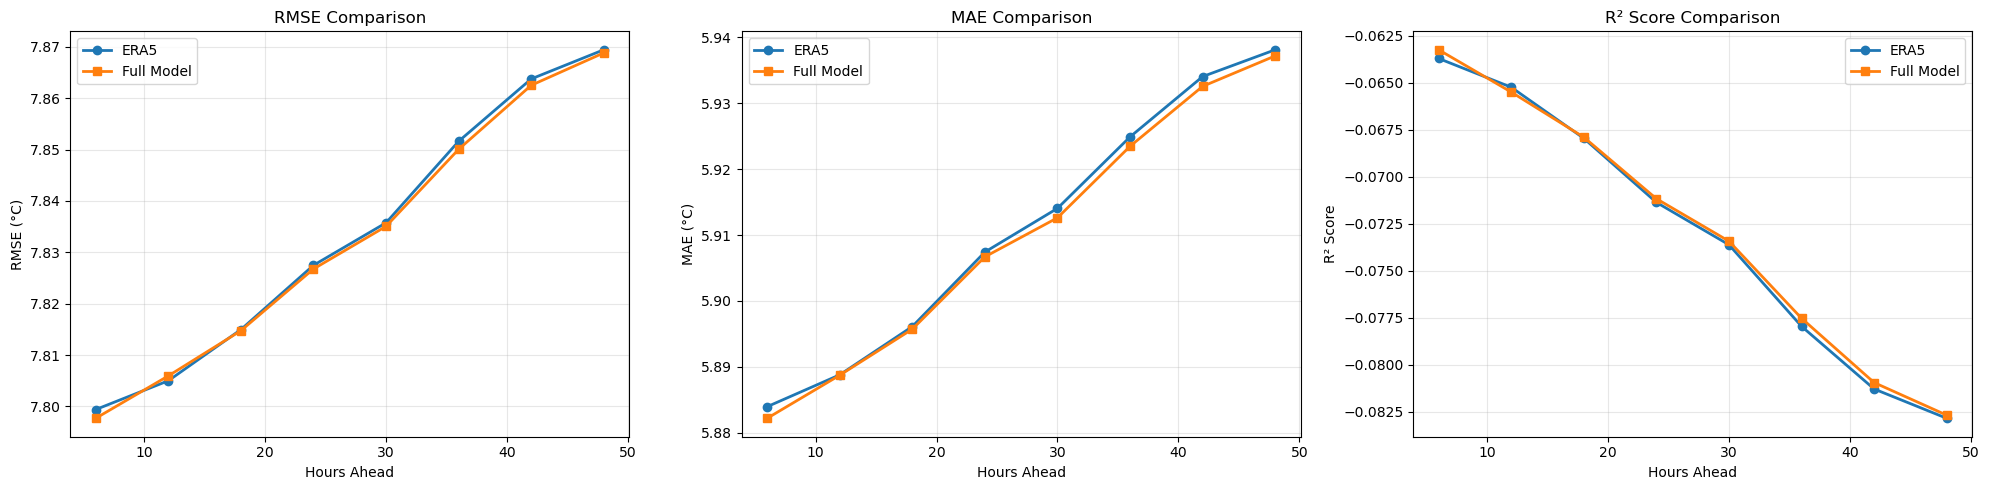

<Figure size 2000x600 with 0 Axes>

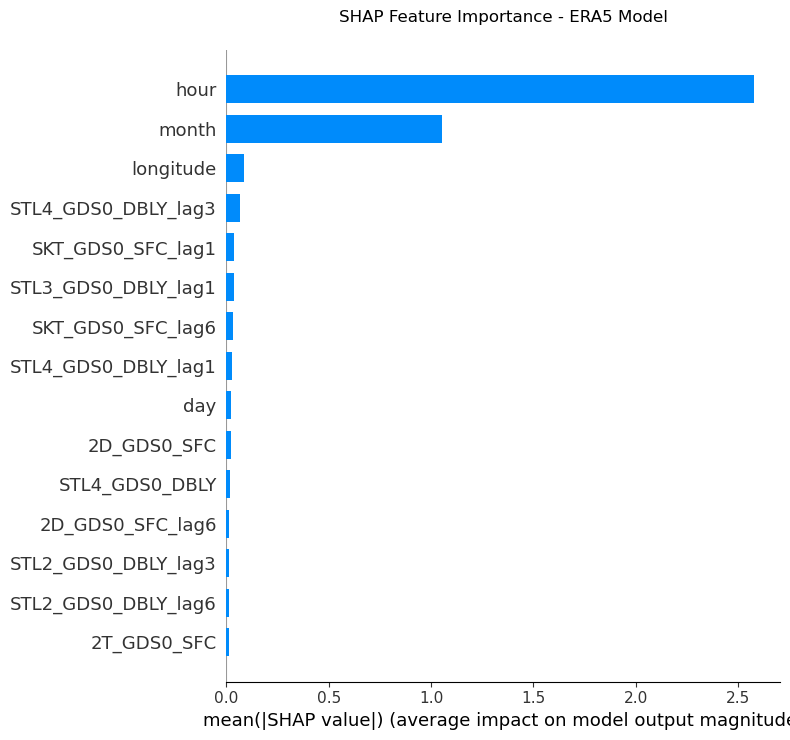

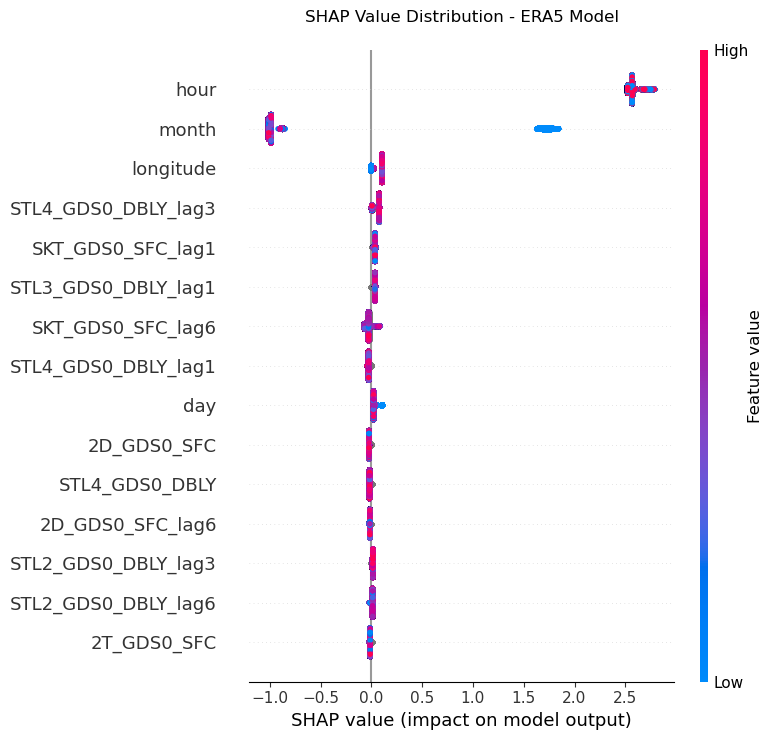

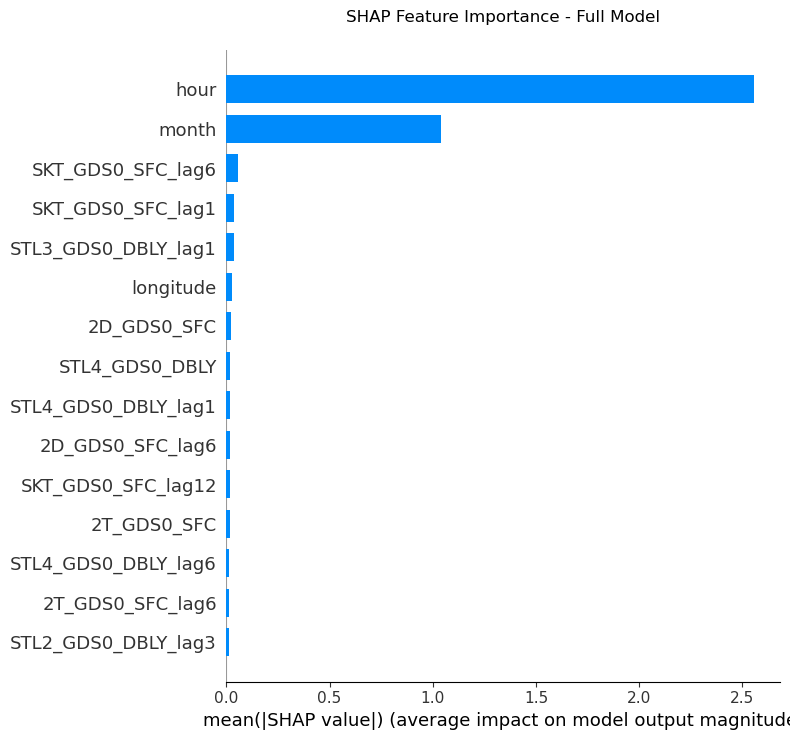

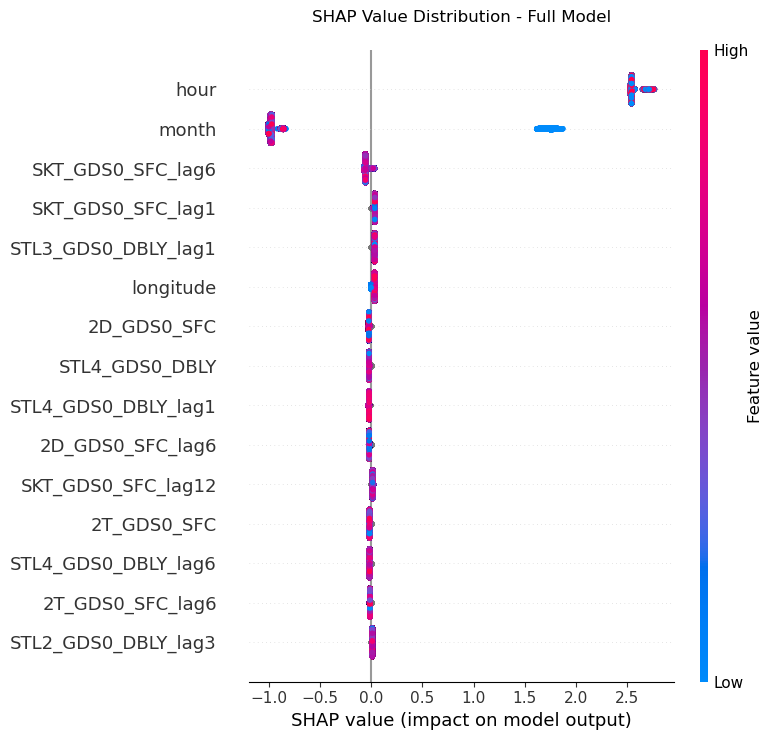


Comparative Summary Statistics:

ERA5 Model:
Average RMSE: 7.833°C
RMSE Range: 7.799°C - 7.869°C
Average R² Score: -0.073

Full Model:
Average RMSE: 7.833°C
RMSE Range: 7.798°C - 7.869°C
Average R² Score: -0.073


In [5]:
if __name__ == '__main__':
    # Load data
    csv_file = 'dataset.csv'
    full_data = pd.read_csv(csv_file)
    
    # Train ERA5 model
    full_data_clean_era5 = preprocess_data(full_data, era5=True, hours_ahead=6)
    y_era5 = full_data_clean_era5['target']
    X_era5 = full_data_clean_era5.drop(columns=['target'])
    train_size = int(len(X_era5) * 0.85)
    X_train_era5, X_test_era5 = X_era5[:train_size], X_era5[train_size:]
    y_train_era5, y_test_era5 = y_era5[:train_size], y_era5[train_size:]
    X_train_era5 = X_train_era5.bfill().ffill()
    X_test_era5 = X_test_era5.bfill().ffill()
    
    # Train non-ERA5 model
    full_data_clean_non_era5 = preprocess_data(full_data, era5=False, hours_ahead=6)
    y_non_era5 = full_data_clean_non_era5['target']
    X_non_era5 = full_data_clean_non_era5.drop(columns=['target'])
    X_train_non_era5, X_test_non_era5 = X_non_era5[:train_size], X_non_era5[train_size:]
    y_train_non_era5, y_test_non_era5 = y_non_era5[:train_size], y_non_era5[train_size:]
    X_train_non_era5 = X_train_non_era5.bfill().ffill()
    X_test_non_era5 = X_test_non_era5.bfill().ffill()
    
    # Train both models
    print("Training ERA5 model...")
    era5_ensemble = WeatherEnsemble()
    era5_ensemble.fit(X_train_era5, y_train_era5)
    print("\nTraining Full model...")
    non_era5_ensemble = WeatherEnsemble()
    non_era5_ensemble.fit(X_train_non_era5, y_train_non_era5)
    
    # Evaluate both models
    print("\nERA5 Model Evaluation:")
    evaluate_model(era5_ensemble, X_test_era5, y_test_era5, "ERA5 Test")
    print("\nFull Model Evaluation:")
    evaluate_model(non_era5_ensemble, X_test_non_era5, y_test_non_era5, "Full Model Test")
    
    # Compare models across time windows
    results_df = evaluate_time_windows(full_data, era5_ensemble, non_era5_ensemble, max_hours=48, step_hours=6, plot=True)